In [1]:
### FILTRAGE COLLABORATIF

import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import TruncatedSVD

In [2]:
# Charger/traiter les données
data = pd.read_csv('../data/raw/raw_recipes.csv')
data = data.drop_duplicates().dropna()
users = pd.read_csv('../data/raw/PP_users.csv')
users = users.drop_duplicates().dropna()
interactions = pd.read_csv('../data/raw/RAW_interactions.csv')
interactions = interactions.drop_duplicates().dropna()

# Filtrer les utilisateurs avec au moins 5 interactions
active_users = interactions['user_id'].value_counts()
filtered_users = active_users[active_users >= 5].index
interactions = interactions[interactions['user_id'].isin(filtered_users)]

# Filtrer les recettes avec au moins 5 interactions
popular_recipes = interactions['recipe_id'].value_counts()
filtered_recipes = popular_recipes[popular_recipes >= 5].index
interactions = interactions[interactions['recipe_id'].isin(filtered_recipes)]

print("\nNombre total de recettes après traitement :", data.shape[0])
print("\nNombre total d'utilisateurs après traitement :", users.shape[0])
print("\nNombre total d'interactions après traitement :", interactions.shape[0])


Nombre total de recettes après traitement : 226657

Nombre total d'utilisateurs après traitement : 25076

Nombre total d'interactions après traitement : 577065


In [3]:
# Créer un utilisateur fictif et lui attribuer des notes à 10 recettes
best_recipes = (
    interactions.groupby('recipe_id')['rating']
    .mean()
    .sort_values(ascending=False)
    .head(10)
    .index
)

new_user_id = users['u'].max() + 1  # Générer un nouvel ID
new_user_ratings = pd.DataFrame({
    'user_id': [new_user_id] * 10,
    'recipe_id': best_recipes,
    #'rating': [4, 3, 5, 2, 5, 1, 3, 4, 5, 5]
    'rating': [1, 5, 2, 5, 3, 5, 3, 2, 4, 2]
})

# Ajouter l'utilisateur fictif aux données d'interactions
interactions = pd.concat([interactions, new_user_ratings], ignore_index=True)

# Créer des mappings pour les utilisateurs et les recettes
user_mapping = {user_id: idx for idx, user_id in enumerate(interactions['user_id'].unique())}
recipe_mapping = {recipe_id: idx for idx, recipe_id in enumerate(interactions['recipe_id'].unique())}

# Mettre à jour les IDs dans les interactions
interactions['user_id'] = interactions['user_id'].map(user_mapping)
interactions['recipe_id'] = interactions['recipe_id'].map(recipe_mapping)

# Construire la matrice creuse
sparse_matrix = csr_matrix((
    interactions['rating'], 
    (interactions['user_id'], interactions['recipe_id'])
))

# Entraîner le modèle k-NN
knn_model = NearestNeighbors(metric='cosine', algorithm='brute')
knn_model.fit(sparse_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [4]:
def get_recommendations_knn(user_id, nResults, n_neighbors):
    user_idx = user_mapping[user_id]
    try:
        # Recherche des voisins
        distances, indices = knn_model.kneighbors(sparse_matrix[user_idx], n_neighbors=n_neighbors)
    except ValueError:
        print("Aucune donnée disponible. Utilisation des recettes les mieux notées globalement.")
        top_recipes = (
            interactions.groupby('recipe_id')['rating']
            .mean()
            .sort_values(ascending=False)
            .head(nResults)
        )
        top_recipe_ids = [key for key, value in recipe_mapping.items() if value in top_recipes.index]
        return data[data['id'].isin(top_recipe_ids)]
    
    # Identifier les utilisateurs similaires
    similar_users = [list(user_mapping.keys())[i] for i in indices.flatten()]
    similar_user_ratings = interactions[interactions['user_id'].isin(similar_users)]
    
    if similar_user_ratings.empty:
        print("Aucun utilisateur similaire trouvé. Utilisation des recettes les mieux notées globalement.")
        top_recipes = (
            interactions.groupby('recipe_id')['rating']
            .mean()
            .sort_values(ascending=False)
            .head(nResults)
        )
        top_recipe_ids = [key for key, value in recipe_mapping.items() if value in top_recipes.index]
        return data[data['id'].isin(top_recipe_ids)]
    
    # Calculer les scores des recettes basés sur les utilisateurs similaires
    top_recipes = similar_user_ratings.groupby('recipe_id')['rating'].mean().sort_values(ascending=False).head(nResults)
    top_recipe_ids = [key for key, value in recipe_mapping.items() if value in top_recipes.index]
    recommended_recipes = data[data['id'].isin(top_recipe_ids)].copy()
    
    # Calculer la fiabilité pour chaque recette
    recipe_reliability = []
    for recipe_id in top_recipes.index:
        # Récupérer les distances des voisins ayant noté cette recette
        user_ids = similar_user_ratings[similar_user_ratings['recipe_id'] == recipe_id]['user_id']
        neighbor_distances = [
            distances[0][i] for i, user in enumerate(similar_users) if user in user_ids.values
        ]
        
        # Fiabilité : inversement proportionnelle à la distance moyenne
        if neighbor_distances:
            mean_distance = sum(neighbor_distances) / len(neighbor_distances)
            reliability = 1 - mean_distance / distances.max()
        else:
            reliability = 0  # Pas de fiabilité si aucun voisin pertinent
        
        recipe_reliability.append(reliability)
    
    # Ajouter les fiabilités aux recommandations
    recommended_recipes['reliability'] = recipe_reliability
    
    return recommended_recipes


In [5]:
# Application de la fonction de recommandation avec k-NN
nRecipes = 1000
nNeighbors = 100
recommendations_knn = get_recommendations_knn(new_user_id, nRecipes, nNeighbors)
print("Nombre de recommandations avec knn: ", recommendations_knn.shape[0])
print(f"Recommandations pour l'utilisateur {new_user_id}:\n")
recommendations_knn.head(nRecipes)

Nombre de recommandations avec knn:  13
Recommandations pour l'utilisateur 25076:



,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,reliability
53786,cinnamon maple granola,256294,50,226066,2007-09-30,"['60-minutes-or-less', 'time-to-make', 'course...","[265.8, 19.0, 63.0, 0.0, 10.0, 12.0, 11.0]",14,"['combine oats , walnuts and coconut in a grea...",from taste of home. i would at least double t...,"['old fashioned oats', 'walnuts', 'flaked coco...",7,0.029398
57264,cooked chicken for recipes barefoot contessa...,234465,50,47907,2007-06-13,"['celebrity', 'lactose', '60-minutes-or-less',...","[289.2, 27.0, 0.0, 3.0, 60.0, 22.0, 0.0]",4,['place chicken breasts on baking sheet with s...,i always poached chicken when i needed cooked ...,"['chicken breasts', 'olive oil', 'salt', 'pepp...",4,0.013806
60195,cran raspberry cooler,266479,130,204024,2007-11-19,"['time-to-make', 'course', 'preparation', 'occ...","[37.3, 0.0, 7.0, 0.0, 0.0, 0.0, 3.0]",5,"['in a 4 quart non-metal container , combine c...",i found this in a pillsbury small cookbook. i ...,['raspberry-cranberry frozen juice concentrate...,4,0.013806
65438,crock pot cajun chicken and shrimp,42725,605,36128,2002-10-08,"['weeknight', 'time-to-make', 'course', 'main-...","[369.4, 10.0, 32.0, 46.0, 85.0, 8.0, 10.0]",4,['put all into crock pot except for last 4 ing...,wonderful creole type dish! this is so little ...,"['skinless chicken thighs', 'red bell pepper',...",15,0.013806
65684,crock pot chops that will make you eat til you...,29544,370,15851,2002-05-29,"['weeknight', 'time-to-make', 'course', 'main-...","[483.7, 28.0, 89.0, 43.0, 88.0, 30.0, 11.0]",6,"['salt and pepper pork chops if desired', 'add...","these have to be, hands down, the best meal i ...","['pork chops', 'onions', 'celery ribs', 'green...",13,0.029398
66980,crumb topped banana muffins,43509,35,27643,2002-10-18,"['60-minutes-or-less', 'time-to-make', 'course...","[220.9, 10.0, 90.0, 12.0, 5.0, 20.0, 12.0]",9,"['in a large bowl , mix the flour , baking sod...",these are so good. we love the topping.,"['flour', 'baking soda', 'baking powder', 'sal...",11,0.013806
73793,dry ranch dressing mix,27560,5,26278,2002-05-07,"['15-minutes-or-less', 'time-to-make', 'course...","[23.7, 0.0, 3.0, 1.0, 2.0, 0.0, 1.0]",6,['put crackers through blender on high speed u...,easy to make and wonderful to have on hand. a ...,"['saltines', 'parsley flakes', 'instant minced...",11,0.013806
86518,french toast sticks oamc,125399,35,95810,2005-06-09,"['60-minutes-or-less', 'time-to-make', 'course...","[199.7, 14.0, 38.0, 9.0, 11.0, 25.0, 7.0]",14,"['preheat oven to 350 degrees fahrenheit', 'cu...",i got this basic recipe from another site but ...,"['bread', 'butter', 'eggs', 'sugar', 'cinnamon...",7,0.013806
92364,gingerbread creamer for coffee or tea gift mix,201503,2,67656,2006-12-21,"['15-minutes-or-less', 'time-to-make', 'course...","[13.0, 1.0, 5.0, 0.0, 0.0, 3.0, 0.0]",3,"['blend well', 'place in a jar , bag or other ...",i discovered this recipe while looking for ite...,"['non-dairy powdered coffee creamer', 'splenda...",7,0.013806
95415,grandma s sourdough biscuits,18995,22,25483,2002-02-06,"['30-minutes-or-less', 'time-to-make', 'course...","[91.3, 6.0, 0.0, 11.0, 3.0, 4.0, 4.0]",8,"['sift together flour , salt , baking powder a...",my grandma makes these every time we go over f...,"['flour', 'salt', 'baking soda', 'baking powde...",6,0.013806


In [6]:
def filter_recommendations(tabRecommendation):
    # Séparer les valeurs de la colonne 'nutrition' en plusieurs colonnes
    nutrition_columns = ['calories', 'total fat (PDV)', 'sugar (PDV)', 'sodium (PDV)', 'protein (PDV)', 'saturated fat (PDV)', 'carbohydrates (PDV)']
    nutrition_data = tabRecommendation['nutrition'].str.strip('[]').str.split(',', expand=True)
    nutrition_data.columns = nutrition_columns

    # Ajouter les nouvelles colonnes au DataFrame original
    tabRecommendation = tabRecommendation.drop(columns=['nutrition'])
    tabRecommendation = pd.concat([tabRecommendation, nutrition_data], axis=1)

    for col in ['calories', 'total fat (PDV)', 'protein (PDV)', 'carbohydrates (PDV)']:
        tabRecommendation[col] = pd.to_numeric(tabRecommendation[col], errors='coerce')

    # Appliquer les contraintes manuellement pour ce premier exemple
    filtered_recommendations = tabRecommendation[
        (tabRecommendation['calories'] <= 700) &
        (tabRecommendation['protein (PDV)'] >= 20) &
        (tabRecommendation['total fat (PDV)'] <= 30) &
        (tabRecommendation['minutes'] <= 40)
    ]

    return filtered_recommendations

In [7]:
# Filtrer les recommandations k-NN avec des contraintes
result = filter_recommendations(recommendations_knn)
print("Nombre de recommandations kNN filtrées : ", result.shape[0])
print(f"Recommandations pour l'utilisateur {new_user_id}:\n")
result.head(nRecipes)

Nombre de recommandations kNN filtrées :  0
Recommandations pour l'utilisateur 25076:



,name,id,minutes,contributor_id,submitted,tags,n_steps,steps,description,ingredients,n_ingredients,reliability,calories,total fat (PDV),sugar (PDV),sodium (PDV),protein (PDV),saturated fat (PDV),carbohydrates (PDV)


In [8]:
# Préparation des données pour SVD
# Réduction de dimension avec SVD 
svd = TruncatedSVD(n_components=50, random_state=42)
svd_model = svd.fit_transform(sparse_matrix)  # Matrice U (représentation des utilisateurs)
svd_components = svd.components_  # Matrice V^T (représentation des recettes)

In [9]:
def get_recommendations_svd(user_id, nResults):
    # Trouver l'index utilisateur
    user_idx = user_mapping[user_id]
    user_ratings = svd_model[user_idx]  # Représentation de l'utilisateur dans l'espace SVD
    
    # Reformater user_ratings en 2D (1, 50) pour l'alignement des dimensions
    user_ratings = user_ratings.reshape(1, -1)
    
    # Prédictions des scores pour toutes les recettes
    predictions = user_ratings.dot(svd_components)  # dimensions alignées : (1, 50) dot (50, n_recipes)
    predictions = predictions.flatten()  # Convertir en vecteur 1D
    
    # Construire les scores pour chaque recette
    recipe_scores = pd.DataFrame({
        'recipe_id': range(len(predictions)),
        'predicted_rating': predictions
    })
    
    # Calculer la fiabilité pour chaque recette : normaliser les prédictions
    max_pred = predictions.max()
    std_pred = predictions.std()
    if std_pred > 0:  # Éviter une division par zéro
        recipe_scores['reliability'] = 1 - (abs(predictions - predictions.mean()) / std_pred)
    else:
        recipe_scores['reliability'] = 1.0  # Si pas de variance, toutes les fiabilités sont maximales
    recipe_scores['reliability'] = recipe_scores['reliability'].clip(lower=0, upper=1) * 100 # Fiabilité entre 0 et 100
    
    # Trier les recettes par score prédictif
    #top_recipes = recipe_scores.sort_values(by='predicted_rating', ascending=False).head(nResults)
   
    # Tri pondéré
    recipe_scores['final_score'] = (
        recipe_scores['predicted_rating'] * 0.7 + 
        (recipe_scores['reliability'] / 100) * 0.3
    )
    # Trier par le score combiné
    top_recipes = recipe_scores.sort_values(by='final_score', ascending=False).head(nResults)

    # Mapper les IDs des recettes
    top_recipe_ids = [key for key, value in recipe_mapping.items() if value in top_recipes['recipe_id'].values]
    recommended_recipes = data[data['id'].isin(top_recipe_ids)].copy()
    
    # Assurez-vous que toutes les recommandations ont une correspondance dans recipe_scores
    recommended_recipes = recommended_recipes.merge(
        recipe_scores[['recipe_id', 'reliability']],
        left_on='id',
        right_on='recipe_id',
        how='left'
    )
    
    # Remplir les NaN dans la colonne de fiabilité (par sécurité)
    recommended_recipes['reliability'] = recommended_recipes['reliability'].fillna(0.0)
    
    return recommended_recipes


In [10]:
# Application de la fonction de recommandation avec SVD
recommendations_svd = get_recommendations_svd(new_user_id, nRecipes)
print("Nombre de recommandations avec svd : ", recommendations_svd.shape[0])
print(f"Recommandations pour l'utilisateur {new_user_id}:\n")
recommendations_svd.head(nRecipes)

Nombre de recommandations avec svd :  975
Recommandations pour l'utilisateur 25076:



,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,recipe_id,reliability
0,real italian bolognese sauce,83950,160,124847,2004-02-14,"['time-to-make', 'course', 'cuisine', 'prepara...","[1260.7, 97.0, 11.0, 71.0, 103.0, 119.0, 38.0]",16,"['in a dutch oven or medium size pot , heat bu...","after traveling throughout italy, savoring the...","['bacon', 'onion', 'celery', 'carrot', 'garlic...",20,NaN,0.00000
1,almost starbucks frappuccino,289671,5,89831,2008-03-02,"['15-minutes-or-less', 'time-to-make', 'course...","[313.0, 19.0, 136.0, 8.0, 10.0, 35.0, 15.0]",6,['in a blender combine coffee with ice cream a...,since i serve this is very large glasses i hav...,"['strong coffee', 'chocolate ice cream', 'choc...",6,NaN,0.00000
2,any muffins,242,40,1530,1999-09-05,"['60-minutes-or-less', 'time-to-make', 'course...","[198.1, 9.0, 33.0, 7.0, 9.0, 16.0, 10.0]",44,"['bake 15 to 20 minutes in a 400 oven', 'for t...",muffins easy to adapt depending on your prefer...,"['white flour', 'milk', 'fat', 'egg', 'sugar',...",7,242.0,0.00000
3,u wing it pork loin chops,21357,65,13483,2002-03-04,"['weeknight', 'time-to-make', 'course', 'main-...","[628.9, 69.0, 14.0, 21.0, 84.0, 65.0, 2.0]",7,"['brown chops in oil in a frying pan', 'remove...","as the name indicates, fix a sauce from ingred...","['pork loin chops', 'olive oil', 'onion', 'gar...",9,21357.0,39.49683
4,1 minute cake,290187,2,584365,2008-03-05,"['15-minutes-or-less', 'time-to-make', 'course...","[183.0, 7.0, 68.0, 10.0, 6.0, 7.0, 10.0]",20,"['mix all dry ingredients', 'add milk , vanill...",it's not a fancy cake but when you eat it warm...,"['flour', 'sugar', 'baking powder', 'cocoa pow...",8,NaN,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
970,zucchini marinata marinated zucchini salad,158292,255,47892,2006-03-02,"['time-to-make', 'course', 'main-ingredient', ...","[54.4, 5.0, 12.0, 0.0, 3.0, 2.0, 1.0]",9,['toss the thinly sliced zucchini with the lem...,a simple marinated zucchini salad from italy.\...,"['zucchini', 'lemon, juice of', 'garlic cloves...",7,NaN,0.00000
971,zucchini mustard chicken burgers,349024,15,197023,2009-01-11,"['15-minutes-or-less', 'time-to-make', 'course...","[278.8, 7.0, 72.0, 6.0, 53.0, 5.0, 12.0]",6,"['mix the chicken , egg white , mustard , papr...",this low gi recipe has been adapted from a rec...,"['ground chicken', 'egg white', 'mustard', 'sw...",15,NaN,0.00000
972,zucchini oven chips,137950,30,185105,2005-09-19,"['30-minutes-or-less', 'time-to-make', 'course...","[72.2, 4.0, 11.0, 6.0, 9.0, 6.0, 2.0]",7,"['preheat oven to 425f', 'combine all ingredie...","this is such a tasty and healthy snack, and so...","['zucchini', 'italian style breadcrumbs', 'fre...",8,NaN,0.00000
973,zuke soup,73089,40,4470,2003-10-10,"['60-minutes-or-less', 'time-to-make', 'course...","[137.2, 14.0, 20.0, 10.0, 9.0, 9.0, 3.0]",8,['saut the onion and zucchini in the margarine...,my neighbor presented me with a 2 foot zucchin...,"['zucchini', 'onion', 'margarine', 'chicken st...",8,NaN,0.00000


In [11]:
# Filtrer les recommandations SVD avec des contraintes
result = filter_recommendations(recommendations_svd)
print("Nombre de recommandations SVD filtrées : ", result.shape[0])
print(f"Recommandations pour l'utilisateur {new_user_id}:\n")
result.head(nRecipes)

Nombre de recommandations SVD filtrées :  138
Recommandations pour l'utilisateur 25076:



,name,id,minutes,contributor_id,submitted,tags,n_steps,steps,description,ingredients,n_ingredients,recipe_id,reliability,calories,total fat (PDV),sugar (PDV),sodium (PDV),protein (PDV),saturated fat (PDV),carbohydrates (PDV)
6,2 pot stove top unstuffed cabbage rolls,143234,35,7108,2005-10-31,"['60-minutes-or-less', 'time-to-make', 'course...",10,"['in one pot , cook rice', 'you will want to e...",i love stuffed cabbage rolls but don't have th...,"['lean ground beef', 'cabbage', 'onion', 'garl...",9,NaN,0.000000,622.3,19.0,45.0,33.0,64.0,25.0,31.0
16,all purpose quick spaghetti sauce,20800,30,5060,2002-02-26,"['30-minutes-or-less', 'time-to-make', 'course...",5,"['in large heavy frypan , cook beef over mediu...","can double, triple this recipe, very basic add...","['lean ground beef', 'onions', 'garlic', 'toma...",9,20800.0,37.425350,196.0,12.0,33.0,11.0,35.0,15.0,4.0
18,almost instantaneous corn chowder,36129,10,10033,2002-08-05,"['15-minutes-or-less', 'time-to-make', 'course...",8,"['in a medium saucepan , bring 2 cups of water...","another great, easy ramen recipe. i've used th...","['ramen noodles', 'water', 'cream-style corn',...",11,36129.0,73.394878,512.8,30.0,30.0,56.0,34.0,53.0,24.0
21,american curried beef,96620,25,121690,2004-07-29,"['curries', '30-minutes-or-less', 'time-to-mak...",8,['cook the onion and garlic in butter until so...,recent research suggests that curry may guard ...,"['onions', 'garlic', 'butter', 'lean ground be...",14,NaN,0.000000,347.3,27.0,29.0,11.0,53.0,41.0,6.0
35,apricot orange barbecued tofu,29771,40,37449,2002-05-30,"['60-minutes-or-less', 'time-to-make', 'course...",7,"['preheat oven to 350f', 'slice the tofu into ...",this is really good. i got this from a book ca...,"['firm tofu', 'oil', 'onion', 'apricot jam', '...",13,29771.0,44.872195,226.9,13.0,81.0,16.0,20.0,7.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
946,wanna be greek grilled chicken breasts,207440,25,237330,2007-01-24,"['30-minutes-or-less', 'time-to-make', 'course...",10,['add a small amount of buttermilk to the hone...,"super easy, flavourful and tender, with a souv...","['boneless skinless chicken breast halves', 'b...",9,NaN,0.000000,196.8,5.0,47.0,20.0,54.0,5.0,4.0
949,weight watchers chicken pot pie,167202,35,316262,2006-05-08,"['60-minutes-or-less', 'time-to-make', 'course...",11,"['preheat oven to 400', 'spray 8x8 casserole d...",4-6 points per serving,"['bisquick reduced-fat baking mix', 'skim milk...",6,NaN,0.000000,230.4,9.0,1.0,6.0,54.0,8.0,5.0
960,world s best chicken noodle soup,71085,25,47510,2003-09-10,"['30-minutes-or-less', 'time-to-make', 'course...",6,['bring water and bouillon cubes to boil in 5 ...,my mom started making this soup after finding ...,"['chicken', 'water', 'chicken bouillon cubes',...",7,NaN,0.000000,392.2,25.0,13.0,57.0,23.0,35.0,16.0
967,zowie cheeseburger,150631,20,177135,2006-01-06,"['30-minutes-or-less', 'time-to-make', 'course...",8,"['mix all of the spices , chopped onion and me...",very flavourful burger...lots of spices...and ...,"['lean ground beef', 'cheddar cheese', 'green ...",12,NaN,0.000000,356.2,23.0,16.0,16.0,57.0,32.0,7.0


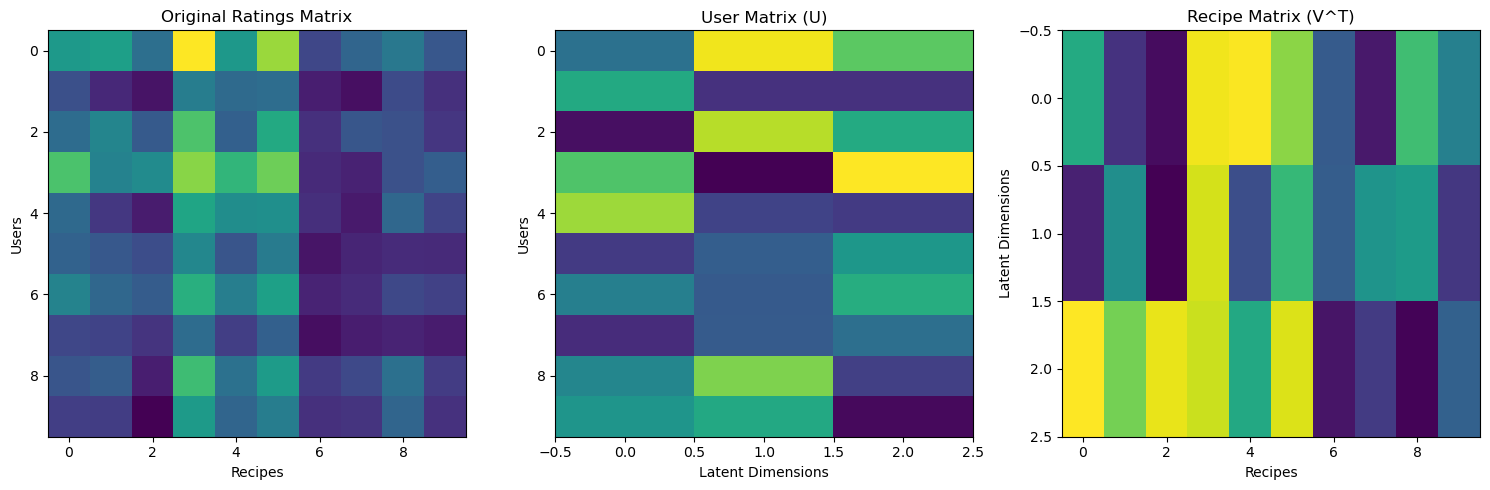

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Parameters for the synthetic illustration
users = 10  # Number of users
recipes = 10  # Number of recipes
k = 3  # Reduced dimensions

# Generate synthetic matrices
np.random.seed(42)
U = np.random.rand(users, k)  # User matrix in latent space
VT = np.random.rand(k, recipes)  # Recipe matrix in latent space

# Compute original ratings (low-rank approximation)
ratings = U.dot(VT)

# Create a figure for illustration
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original matrix (ratings matrix)
axes[0].imshow(ratings, aspect='auto', cmap='viridis')
axes[0].set_title("Original Ratings Matrix")
axes[0].set_xlabel("Recipes")
axes[0].set_ylabel("Users")

# User latent space representation
axes[1].imshow(U, aspect='auto', cmap='viridis')
axes[1].set_title("User Matrix (U)")
axes[1].set_xlabel("Latent Dimensions")
axes[1].set_ylabel("Users")

# Recipe latent space representation
axes[2].imshow(VT, aspect='auto', cmap='viridis')
axes[2].set_title("Recipe Matrix (V^T)")
axes[2].set_xlabel("Recipes")
axes[2].set_ylabel("Latent Dimensions")

# Adjust layout
plt.tight_layout()
plt.show()
